In [1]:
from pathlib import Path
import os

if '__setup_done' not in globals():
    os.chdir("..")
    __setup_done = True
    print("디렉토리 변경 완료")
else:
    print("이미 실행됨 - 스킵")

Path.cwd()

디렉토리 변경 완료


WindowsPath('d:/02_Projects/Dev/X-ray_AI/Reflecto/runs/exp04_one_genx')

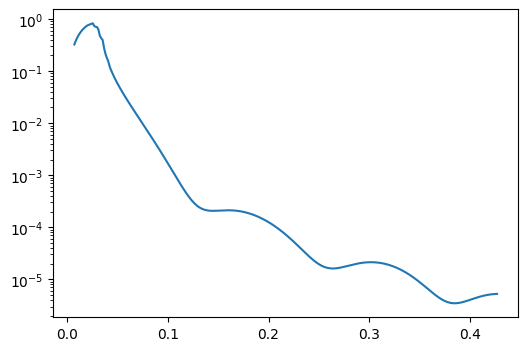

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from genx.plugins.add_ons.help_modules.frequency_analysis import TransformType, transform

from reflecto.simulate.simul_genx import XRRSimulator, tth2q_wavelen, ParamSet, params2refl
wavelen: float = 1.54  # (nm)
tth_min: float = 0.1   # degree
tth_max: float = 6.0
tth_n: int = 300
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

param = ParamSet(50, 0, 1)
params = [param]
refl = params2refl(params, qs)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

In [3]:
import numpy as np

from genx.model import Model
from genx.data import DataList, DataSet
from genx.parameters import Parameters

# 1) 측정 데이터 준비
qz = qs
R  = refl
dR = np.maximum(refl*0.3, 1e-8)  # 0 에러 방지 권장

ds = DataSet(name="XRR 1-layer")
ds.x_raw = qz
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

# 2) 스크립트 (SLD -> b는 1e5를 곱함)
script_text = rf"""
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType

initial_thickness = {param.thickness}
initial_roughness = {param.roughness}
initial_sld = {param.sld * 10e-6}  # Å^-2

SI_SLD = 2.07e-6  # Å^-2

class Vars:
    def __init__(self, d, sigma, sld):
        self._d = float(d)
        self._sigma = float(sigma)
        self._sld = float(sld)
    def set_thickness(self, v): self._d = float(v)
    def get_thickness(self):    return self._d
    def set_roughness(self, v): self._sigma = float(v)
    def get_roughness(self):    return self._sigma
    def set_sld(self, v): self._sld = float(v)
    def get_sld(self):    return self._sld

vars = Vars(initial_thickness, initial_roughness, initial_sld)

Amb  = Layer(d=0.0, dens=0.0, f=0.0)
Sub  = Layer(d = 0.0, f=SI_SLD*1e5, dens=1.0, sigma=3.0)  # ← 1e5
Film = Layer(d=vars.get_thickness(),
             sigma=vars.get_roughness(),
             f=vars.get_sld(),  # X-ray SLD 값 (단위 주의: 통상 10^-6 A^-2)
             dens=1.0)

sample = Sample(Stacks=[Stack(Layers=[Film])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray,
    wavelength=1.54,
    coords=Coords.q,
    I0=1.0,
    Ibkg=1e-10,
    res=0.005,
    restype=ResType.fast_conv, # 분해능 컨볼루션
    footype=FootType.gauss
)

def _sync():
    Film.d     = vars.get_thickness()
    Film.sigma = vars.get_roughness()
    Film.b     = vars.get_sld()*1e5

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""

# 3) 모델 생성 및 스크립트 설정
model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# 4) 피팅 파라미터/경계 설정
thickness_min, thickness_max = 10.0, 200.0
roughness_min, roughness_max = 0.0, 15.0
sld_min, sld_max             = 1.0e-6, 6.0e-6

pars = Parameters()

p = pars.append("vars.set_thickness", model)
p.fit = True
p.value = param.thickness
p.min = thickness_min
p.max = thickness_max

p = pars.append("vars.set_roughness", model)
p.fit = True
p.value = param.roughness
p.min = roughness_min
p.max = roughness_max

p = pars.append("vars.set_sld", model)
p.fit = True
p.value = param.sld * 1e-6
p.min = sld_min;  
p.max = sld_max

model.parameters = pars

# 5) 피팅 실행
res = model.bumps_fit(method="dream", samples=5e4, burn=2000, thin=5)
model.bumps_update_parameters(res)
model.evaluate_sim_func()

# 6) 결과
print("Best-fit parameters:")
for par in model.parameters:
    if par.fit:
        print(f"  {par.name} = {par.value}")
print(f"FOM = {model.fom}")


Best-fit parameters:
  vars.set_thickness = 48.918378809702425
  vars.set_roughness = 0.046539344008625284
  vars.set_sld = 1.0123393840653818e-06
FOM = 1.62281464423435


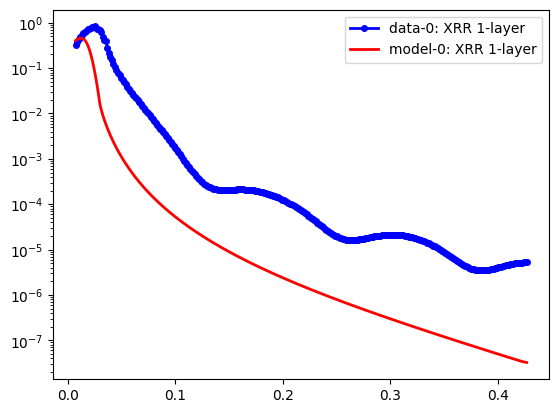

In [5]:
from genx.model_control import ModelController
from genx.diffev import DiffEv

controller = ModelController(DiffEv())
controller.set_model(model)
controller.StartFit()

fitted = controller.get_fitted_model()
fitted.simulate()
fitted.data.plot()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()